In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.preprocessing import Normalizer, LabelBinarizer
from sklearn.model_selection import train_test_split

%matplotlib notebook

In [2]:
%matplotlib notebook

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import timeit
start_time = timeit.default_timer()
# code you want to evaluate


# Read input files and do some filtering & preprocessing

The database contains a lot of useless information, so we do some cleaning up to make it useable for our purposes.

In [5]:
raw = pd.read_csv('initial_db.csv')

In [6]:
print(raw.head())

  pretty_formula full_formula material_id  temperature    eV  n_units_in_cell  \
0          BaSi2      Ba8Si16     mp-1477          100 -0.50             24.0   
1          BaSi2      Ba8Si16     mp-1477          100 -0.48             24.0   
2          BaSi2      Ba8Si16     mp-1477          100 -0.46             24.0   
3          BaSi2      Ba8Si16     mp-1477          100 -0.44             24.0   
4          BaSi2      Ba8Si16     mp-1477          100 -0.42             24.0   

   atomic_mass variance  atomic_mass mean  electrical_resistivity variance  \
0           2651.934516         64.499333                              NaN   
1           2651.934516         64.499333                              NaN   
2           2651.934516         64.499333                              NaN   
3           2651.934516         64.499333                              NaN   
4           2651.934516         64.499333                              NaN   

   electrical_resistivity mean     ...      

In [7]:
raw.describe()

,temperature,eV,n_units_in_cell,atomic_mass variance,atomic_mass mean,electrical_resistivity variance,electrical_resistivity mean,atomic_radius variance,atomic_radius mean,X variance,...,Seebeck_yy,Seebeck_zz,Seebeck_xy,Seebeck_xz,Seebeck_yx,Seebeck_yz,Seebeck_zx,Seebeck_zy,zt,Unnamed: 95
count,88740.000000,8.874000e+04,88740.000000,88740.000000,88740.000000,0.0,0.0,88740.000000,88740.000000,88740.000000,...,88740.000000,88740.000000,8.874000e+04,8.874000e+04,8.874000e+04,88740.000000,8.874000e+04,8.874000e+04,88740.000000,0.0
mean,450.000000,2.392096e-18,19.603448,1410.764845,57.493800,NaN,NaN,0.074019,1.344114,0.085892,...,4.149247,5.356624,-4.500427e-01,-3.107046e-01,3.736675e+00,0.639730,5.632767e+00,-1.427871e+00,0.112034,NaN
std,216.025907,2.943937e-01,24.208955,1669.030682,27.605521,NaN,NaN,0.067454,0.138369,0.074472,...,189.961172,186.589486,2.551478e+01,2.154723e+01,1.308281e+02,130.132988,2.368672e+02,4.886558e+01,0.429289,NaN
min,100.000000,-5.000000e-01,2.000000,1.853791,10.856648,NaN,NaN,0.000556,1.033333,0.000000,...,-4022.989960,-3959.276730,-2.294004e+03,-1.639647e+03,-3.418480e+03,-2583.595550,-7.799324e+03,-1.146517e+04,0.000000,NaN
25%,250.000000,-2.600000e-01,7.750000,133.160990,37.850062,NaN,NaN,0.020000,1.250000,0.016706,...,-16.548034,-16.028816,-7.103325e-01,-7.102891e-02,-3.843469e-01,-0.097070,-4.444218e-02,-5.613434e-02,0.001301,NaN
50%,450.000000,0.000000e+00,9.000000,662.423973,48.490767,NaN,NaN,0.028711,1.319901,0.083113,...,-1.333610,-1.353205,5.202476e-16,-6.712583e-17,6.292552e-14,0.000001,6.812742e-15,3.556377e-15,0.008263,NaN
75%,650.000000,2.600000e-01,24.750000,2833.126897,75.352754,NaN,NaN,0.113111,1.406250,0.147456,...,14.146497,15.025164,6.767042e-01,6.251231e-02,1.801244e+00,0.125938,1.228243e-01,1.064971e-01,0.043819,NaN
max,800.000000,5.000000e-01,152.000000,5476.618880,142.732285,NaN,NaN,0.270000,1.756250,0.249820,...,4162.527470,4031.233360,2.431405e+03,1.505644e+03,1.000483e+04,37524.482300,1.617259e+04,1.438888e+03,7.669746,NaN


In [8]:
# drop tensor values (except _xx)
suffix = ['_yy', '_zz', '_xy', '_xz', '_yz', '_zy', '_yx', '_zx']
dontcare = [variable + s for variable in ['Sigma', 'Kappae', 'Seebeck'] for s in suffix]
db = raw.drop(dontcare, axis=1)

# drop Nan values
db = db.drop(['electrical_resistivity variance', 'electrical_resistivity mean'], axis=1)

# drop meta information
# db = db.drop(['pretty_formula', 'full_formula', 'material_id'], axis=1)

# Delete bogus input material mp-569825
db = db[db.material_id != 'mp-569825']

# Delete all-zero columns
ignore_columns = (db != 0).any(axis=0)
db = db.loc[:, ignore_columns]

# remove linear dependent features
db = db.drop(['Total group #15', 'Total row #8'], axis=1)

In [9]:
db.describe()

,temperature,eV,n_units_in_cell,atomic_mass variance,atomic_mass mean,atomic_radius variance,atomic_radius mean,X variance,X mean,valence_electrons variance,...,Total 5d electrons,density,e_above_hull,symmetry_group,band_gap,Sigma_xx,Kappae_xx,Seebeck_xx,zt,Unnamed: 95
count,87975.000000,8.797500e+04,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,...,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,8.797500e+04,8.797500e+04,87975.000000,8.797500e+04,0.0
mean,450.000000,2.422993e-18,19.539130,1386.395712,57.316627,0.073806,1.344143,0.085701,1.658856,1.018592,...,0.252174,5.319324,0.022573,150.565217,0.056149,2.014868e+07,2.196639e+02,6.744336,1.130081e-01,NaN
std,216.025918,2.943937e-01,24.304114,1655.596246,27.659541,0.067708,0.138969,0.074767,0.218664,0.417370,...,0.778447,2.462400,0.037993,63.804428,0.166337,3.169648e+07,3.996356e+02,205.362454,4.310242e-01,NaN
min,100.000000,-5.000000e-01,2.000000,1.853791,10.856648,0.000556,1.033333,0.000000,1.150370,0.000000,...,0.000000,1.194592,0.000000,12.000000,0.000000,7.301594e-17,6.899163e-21,-4889.808090,1.308426e-20,NaN
25%,250.000000,-2.600000e-01,7.000000,127.048176,37.850062,0.020000,1.250000,0.016200,1.510000,0.888889,...,0.000000,3.511088,0.000000,63.000000,0.000000,1.809763e+06,1.608211e+01,-15.168533,1.382204e-03,NaN
50%,450.000000,0.000000e+00,9.000000,537.213126,48.490767,0.028711,1.318750,0.079921,1.675000,0.937500,...,0.000000,5.326862,0.000539,180.000000,0.000000,8.055944e+06,7.223950e+01,-0.653704,8.498186e-03,NaN
75%,650.000000,2.600000e-01,24.000000,2803.322503,74.903286,0.114844,1.425000,0.148225,1.820000,1.000000,...,0.000000,6.910636,0.029412,205.000000,0.000000,2.117247e+07,2.225874e+02,15.452140,4.447916e-02,NaN
max,800.000000,5.000000e-01,152.000000,5476.618880,142.732285,0.270000,1.756250,0.249820,2.095000,2.250000,...,4.000000,13.914380,0.150475,225.000000,0.797800,1.840914e+08,1.079191e+04,6923.884040,7.669746e+00,NaN


In [10]:
j = 0
for i in db:
    print(j, i)
    j+=1

0 pretty_formula
1 full_formula
2 material_id
3 temperature
4 eV
5 n_units_in_cell
6 atomic_mass variance
7 atomic_mass mean
8 atomic_radius variance
9 atomic_radius mean
10 X variance
11 X mean
12 valence_electrons variance
13 valence_electrons mean
14 Total group #1
15 Total group #2
16 Total group #3
17 Total group #4
18 Total group #5
19 Total group #6
20 Total group #7
21 Total group #8
22 Total group #9
23 Total group #10
24 Total group #11
25 Total group #12
26 Total group #14
27 Total row #2
28 Total row #3
29 Total row #4
30 Total row #5
31 Total row #6
32 Total 1s electrons
33 Total 2s electrons
34 Total 2p electrons
35 Total 3s electrons
36 Total 3p electrons
37 Total 4s electrons
38 Total 3d electrons
39 Total 4p electrons
40 Total 5s electrons
41 Total 4d electrons
42 Total 5p electrons
43 Total 6s electrons
44 Total 4f electrons
45 Total 5d electrons
46 density
47 e_above_hull
48 symmetry_group
49 crystal
50 band_gap
51 Sigma_xx
52 Kappae_xx
53 Seebeck_xx
54 zt
55 Unnamed

In [11]:
db['crystal'].unique()

array(['orthorhombic', 'hexagonal', 'cubic', 'monoclinic', 'tetragonal',
       'trigonal'], dtype=object)

In [12]:
lb = LabelBinarizer()
i = list(range(3,46)) + [50]
X = np.hstack((db.iloc[:, i].values, lb.fit_transform(db['crystal'])))
y = db['zt'].values
global_i = np.arange(0,X.shape[0])
print(i)
print(X.shape)
print(lb.fit_transform(db['crystal']).shape)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 50]
(87975, 50)
(87975, 6)


x = ['band_gap', 'density']
print(db[x].values)

### Look for the nasty outliers (such as materials with all-zero input)

Turns out that this is the material 'mp-569825' which has 765 entries and we need to remove.

In [13]:
### we remove this from the db object instead (code below no longer needed)
# i = np.where(y==0)
# print(raw.iloc[i].describe())

In [14]:
# print(raw['material_id'].iloc[i[0][0]]) # first all-zero compound
# print(raw['material_id'].iloc[i[0][-1]]) # last all-zero compound

In [15]:
# X = np.delete(X, i, axis=0)
# y = np.delete(y, i, axis=0)
# print(X.shape)

In [16]:
#Keep rows which are finite (do not have NAn, Infinity)

In [17]:
X=X[np.isfinite(X).all(axis=1)]

### OPTIONAL: we may drastically reduce dataset size by only considering T=300 kelvin

This is a reasonable assumption as this is the interesting case to consider

global_i = np.where(X[:,0] == 300)
X = X[global_i,:].squeeze()
y = y[global_i].squeeze()
print(X.shape)
print(y.shape)
global_i = global_i[0]
print(global_i)

### Normalize input vectors

In [18]:
### Normalize input vectors (not one-hot encoded values!)

X_mean = X.mean(axis=0)
X_std  = X.std(axis=0)
X_std[np.where(np.isclose(X_std,0))] = 1
X  = np.apply_along_axis(lambda x:(x-X_mean)/X_std, axis=1, arr=X)


# y is already nicely scaled
# ymin = np.min(y)
# ymax = np.max(y)
# dy = ymax - ymin
# y = (y-ymin)/(ymax-ymin)
# y = y / ymax

In [19]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
#          'figure.figsize': (20, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
plt.rcParams['font.size']=18
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [20]:
### debug print to check that scaling worked
print(X.mean(axis=0))
print(X.std(axis=0))
print(X_std)
# print(np.where(X.std(axis=0) == 0.0))
print('y-range [{}, {}], std(y)={}'.format(np.min(y), np.max(y), y.std()))
# print(ymin, ymax)

[ -4.34119603e-19   5.04790236e-21  -1.19556236e-14  -8.82201577e-14
   6.87244188e-13   5.60759113e-13  -4.19733240e-13   6.31737307e-14
   6.79300662e-14  -4.94794660e-13  -1.73056965e-12   1.87251130e-14
  -5.46433285e-15  -7.63964907e-14  -1.35473982e-14   5.30272741e-14
  -3.58873646e-14   8.88077638e-14   1.54208893e-14   5.66720697e-14
  -2.74148447e-14   1.42494055e-14   6.84127952e-14  -3.69965332e-14
   1.15430787e-14   3.25478749e-14   5.02033324e-15   1.50425976e-15
   6.71806080e-14   0.00000000e+00  -1.14223329e-14   3.43689461e-14
  -5.69711914e-14  -4.07911297e-14   2.11739615e-14   3.51157176e-14
   9.39462281e-14   6.63764355e-14  -4.70000976e-14   2.99234806e-14
   2.12152155e-14  -5.10127560e-14   7.30108355e-14  -9.12399643e-15
   1.27080538e-14   5.29851708e-14   8.23934154e-14  -6.20407644e-14
   9.47432250e-14   5.03198373e-14]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1

In [21]:
# we keep the indices so we can backtrack to identify problems
# y = np.vstack([y, list(range(len(y)))]).T


In [22]:
#IMPORTANT Split into training, and testing set

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
i=51*60*15
j=51*77*15
X_train=X[:i,:]
#X_train.append(X[j:,:])
X_train=np.concatenate((X_train,X[j:,:]),axis=0)

X_test=X[i:j,:]
print(type(y),y.shape)

y_train=y[:i]
print(y_train.shape,i)
y_train=np.concatenate((y_train,y[j:]))

y_test=y[i:j]

from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
print(type(y_train))

<class 'numpy.ndarray'> (87975,)
(45900,) 45900
(74970, 50) (13005, 50)
(74970,) (13005,)
<class 'numpy.ndarray'>


In [23]:
print(i)

45900


In [24]:
#print(train_i)
# print(test_i)
# print(type(test_i))
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)
print(X_train.shape[0] / 15 / 51)
print(X_test.shape[0]  / 15 / 51)

(74970, 50)
(13005, 50)
(13005,)
(74970,)
98.0
17.0


# Build Artifical Neural Network model (Regression)

### Use this model for big dataset (all temperatures)

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers


model = Sequential()
model.add(Dense( units= 50, activation='tanh',bias_initializer='glorot_uniform', input_dim=X.shape[1],))
model.add(Dense( units= 43, activation='tanh',bias_initializer='glorot_uniform'))
model.add(Dense( units= 20, activation='relu'))
model.add(Dense( units= 20, activation='relu'))
model.add(Dense( units= 15, activation='tanh'))
model.add(Dense( units= 10, activation='tanh'))
model.add(Dense( units=  5, activation='tanh'))
model.add(Dense( units=  1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')


Using TensorFlow backend.


### Use this model for small dataset (only T=300 K)

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

alpha = 0.00008 # regularization weight

model = Sequential()
model.add(Dense( kernel_regularizer=regularizers.l2(alpha), units= 24, activation='tanh', bias_initializer='glorot_uniform', input_dim=X.shape[1]))
model.add(Dropout(.2))
model.add(Dense( kernel_regularizer=regularizers.l2(alpha), units= 21, activation='tanh'))
model.add(Dropout(.2))
# model.add(Dense( kernel_regularizer=regularizers.l2(alpha), units= 10, activation='tanh'))
model.add(Dense( kernel_regularizer=regularizers.l2(alpha), units= 7, activation='tanh'))
model.add(Dense( kernel_regularizer=regularizers.l2(alpha), units=  1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

### Load model from file

from keras.models import load_model
model = load_model('ANN-zt-test-R2-071.h5')
train_i = np.load('ANN-zt-test-R2-071-train-i.npy')
test_i  = np.load('ANN-zt-test-R2-071-test-i.npy')
X_train = X[train_i,:]
X_test  = X[test_i ,:]
y_train = y[train_i]
y_test  = y[test_i]

<IPython.core.display.Javascript object>


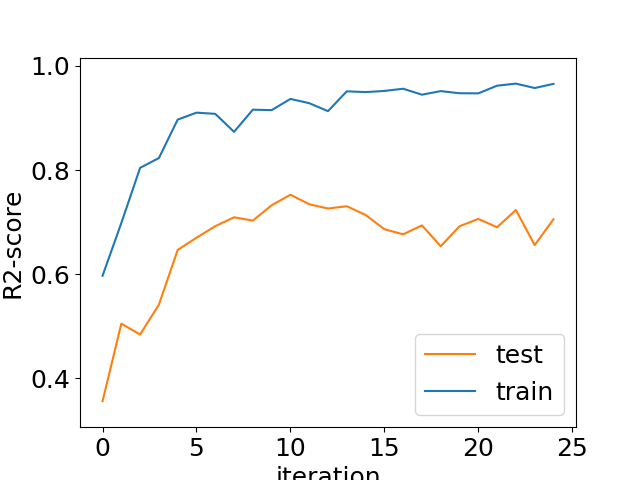

Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 2s - loss: 0.0847 - val_loss: 0.2474
Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 1s - loss: 0.0526 - val_loss: 0.1902
Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 1s - loss: 0.0386 - val_loss: 0.1982
Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 1s - loss: 0.0297 - val_loss: 0.1761
Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 1s - loss: 0.0238 - val_loss: 0.1357
Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 1s - loss: 0.0189 - val_loss: 0.1267
Train on 74970 samples, validate on 13005 samples
Epoch 1/1
74970/74970 [==============================] - 1s - loss: 0.0163 - val_loss:

In [26]:
mu  = y_train.mean()
mu2 = y_test.mean()
err_mean_model_train = np.power(y_train - mu,  2)
err_mean_model_test  = np.power(y_test  - mu2, 2)

epochs = 25
R2_train = np.zeros((epochs,1))
R2_test  = np.zeros((epochs,1))

fig,ax = plt.subplots(1,1)
ax.plot(R2_test,  color='#ff7f0e')
ax.plot(R2_train, color='#1f77b4')
ax.legend(['test', 'train'], loc=4)
ax.set_xlabel('iteration')
ax.set_ylabel('R2-score')

for epoch in range(epochs):
    model.fit(X_train, y_train, epochs=1, batch_size=125, validation_data=(X_test, y_test))
    
    # print R2-score
    err_train = np.power(y_train - model.predict(X_train).squeeze(), 2)
    err_test  = np.power(y_test  - model.predict(X_test ).squeeze(), 2)
    
    R2_train[epoch:] = 1 - np.sum(err_train) / np.sum(err_mean_model_train)
    R2_test[ epoch:] = 1 - np.sum(err_test ) / np.sum(err_mean_model_test)
    ax.lines[0].set_ydata(R2_test)
    ax.lines[1].set_ydata(R2_train)
    
    ax.lines[0].set_xdata(list(range(epoch)) + [epoch]*(epochs-epoch))
    ax.lines[1].set_xdata(list(range(epoch)) + [epoch]*(epochs-epoch))
    ax.set_ylim([np.min([R2_train, R2_test])-.05, np.max([R2_train, R2_test])+.05])
    fig.canvas.draw()
    # plt.plot(R2_test,  color='#ff7f0e')
    # plt.plot(R2_train, color='#1f77b4')
    
    # display.clear_output(wait=True)
    # display.display(plt.gcf())

In [27]:
epochs

25

#fig,ax = plt.subplots(1,2, figsize=(10,4))
fig,ax = plt.subplots(1,1, figsize=(10,4))
yy_train = model.predict(X_train)
yy_test  = model.predict(X_test)
s0 = max(np.min(yy_train), np.min(y_train))
s1 = min(np.max(yy_train), np.max(y_train))
ax[0].plot(y_train, yy_train, 'o ', markeredgewidth=1, markeredgecolor='k')
ax[0].plot(y_test , yy_test , 'o ', markeredgewidth=1, markeredgecolor='k')
ax[0].plot([s0,s1], [s0,s1], '--', linewidth=3)
ax[0].plot(np.zeros(51), np.zeros(51), 'o ', markeredgewidth=1, markeredgecolor='k')
ax[0].set_xlabel('actual')
ax[0].set_ylabel('predicted')
ax[0].legend(['Train (R2 - 0.95)', 'Test (R2 - 0.34)', 'Perfect fit', ''])
ax[0].set_title('Predicted vs actual y values')
text=ax[0].text(2.5,-0.2, "", va="bottom", ha="left")
annot = ax[0].annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                       bbox=dict(boxstyle="round", fc="w"),
                       arrowprops=dict(arrowstyle="->"))
#ax[1].plot(np.linspace(-.5,.5,51), np.zeros(51), 'o-', markeredgewidth=1, markeredgecolor='k', color='#d62728')
#ax[1].plot(np.linspace(-.5,.5,51), np.zeros(51), color='#2ca02c')
#ax[1].legend(['Predicted', 'Exact'])
#ax[1].set_xlabel('chemical potential (eV)')
#ax[1].set_ylabel('Figure-of-merit: zt')

train = np.vstack([y_train, yy_train.squeeze()])
test  = np.vstack([y_test,  yy_test.squeeze()] )

def onclick(event):

    click_xy = np.array([event.xdata, event.ydata])
    dist1 = np.apply_along_axis(lambda x : np.linalg.norm(x-click_xy), axis=0, arr=train)
    dist2 = np.apply_along_axis(lambda x : np.linalg.norm(x-click_xy), axis=0, arr=test)
    i = np.argmin(dist1)
    j = np.argmin(dist2)
    if dist1[i] < dist2[j]:
        mat_id = db['material_id'].iloc[train_i[i]]
        name = 'Train:{} ({}) T={}'.format(db['pretty_formula'].iloc[train_i[i]], db['material_id'].iloc[train_i[i]], db['temperature'].iloc[train_i[i]])
#        annot.set_text('%s'%(db['pretty_formula'].iloc[train_i[i]]))
#db['pretty_formula'].iloc[train_i[i]],db['eV'].iloc[train_i[i]],db['temperature'].iloc[train_i[i]]))       
#        annot.xy = train[:,i]
        k  = train_i[i] // 51
        k  = np.arange(k*51,(k+1)*51)
        k  = np.array([j for j,ii in enumerate(train_i)  if ii in k])
        X0 = X_train[k,:]
        y0 = y_train[k]
    else:
        mat_id = db['material_id'].iloc[test_i[j]]
        name = 'Test:{} ({}) T={}'.format(db['pretty_formula'].iloc[test_i[j]], db['material_id'].iloc[test_i[j]], db['temperature'].iloc[test_i[j]])
#        annot.set_text('%s'%(db['pretty_formula'].iloc[test_i[j]]))
        #db['material_id'].iloc[test_i[j]],db['eV'].iloc[test_i[j]],db['temperature'].iloc[test_i[j]]
#        annot.xy = test[:,j]
        k  = test_i[j] // 51
        k  = np.arange(k*51,(k+1)*51)
        k  = np.array([j for j,ii in enumerate(test_i)  if ii in k])
        X0 = X_test[k,:]
        y0 = y_test[k]

    # k  = np.arange(k*51,(k+1)*51)
    # k1 = np.array([j for j,ii in enumerate(test_i)  if ii in k])
    # k2 = np.array([j for j,ii in enumerate(train_i) if ii in k])
    # X0 = np.vstack((X_test[k1,:], X_train[k2,:])).squeeze()
    # y0 = np.hstack((y_test[k1],   y_train[k2])).squeeze()
    # i  = np.argsort(X0[:,1])
    # X0 = X0[i,:]
    # y0 = y0[i]
    y1 = model.predict(X0).squeeze()
#    ax[1].lines[0].set_ydata(y1)
#    ax[1].lines[1].set_ydata(y0)
#    ax[1].set_ylim([np.min([y0,y1])-0.1, np.max([y0,y1])+.1])
#    ax[1].set_title(name)
    ax[0].lines[3].set_xdata(y0)
    ax[0].lines[3].set_ydata(model.predict(X0).squeeze())
    ax[0].legend(['Train (R2-0.95)', 'Test (R2-0.34)', 'Perfect fit']) 
    # , mat_id
    fig.canvas.draw()
    
fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()



In [29]:
print(y_train)

[ 0.0065262   0.00630882  0.09672168 ...,  0.06743467  0.02560195
  0.0026628 ]


<IPython.core.display.Javascript object>


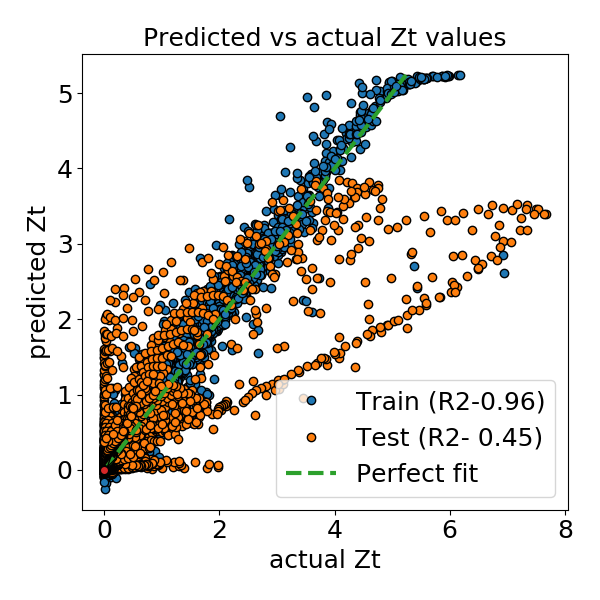

r2 score 0.965599532516 0.705386799826


In [30]:
#fig,ax = plt.subplots(1,2, figsize=(10,4))
fig,ax = plt.subplots(1,1, figsize=(6,6))
yy_train = model.predict(X_train)
yy_test  = model.predict(X_test)
# print R2-score
err_train = np.power(y_train - model.predict(X_train).squeeze(), 2)
err_test  = np.power(y_test  - model.predict(X_test ).squeeze(), 2)
R2_train = 1 - np.sum(err_train) / np.sum(err_mean_model_train)
R2_test = 1 - np.sum(err_test ) / np.sum(err_mean_model_test)
print('r2 score',R2_train,R2_test)    
s0 = max(np.min(yy_train), np.min(y_train))
s1 = min(np.max(yy_train), np.max(y_train))
ax.plot(y_train, yy_train, 'o ', markeredgewidth=1, markeredgecolor='k')
ax.plot(y_test , yy_test , 'o ', markeredgewidth=1, markeredgecolor='k')
ax.plot([s0,s1], [s0,s1], '--', linewidth=3)
ax.plot(np.zeros(51), np.zeros(51), 'o ', markeredgewidth=1, markeredgecolor='k')
ax.set_xlabel('actual Zt')
ax.set_ylabel('predicted Zt')
ax.legend(['Train (R2-0.96)', 'Test (R2- 0.45)', 'Perfect fit'])
ax.set_title('Predicted vs actual Zt values')
text=ax.text(2.5,-0.2, "", va="bottom", ha="left")
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                       bbox=dict(boxstyle="round", fc="w"),
                       arrowprops=dict(arrowstyle="->"))
#ax[1].plot(np.linspace(-.5,.5,51), np.zeros(51), 'o-', markeredgewidth=1, markeredgecolor='k', color='#d62728')
#ax[1].plot(np.linspace(-.5,.5,51), np.zeros(51), color='#2ca02c')
#ax[1].legend(['Predicted', 'Exact'])
#ax[1].set_xlabel('chemical potential (eV)')
#ax[1].set_ylabel('Figure-of-merit: zt')

train = np.vstack([y_train, yy_train.squeeze()])
test  = np.vstack([y_test,  yy_test.squeeze()] )

def onclick(event):

    click_xy = np.array([event.xdata, event.ydata])
    dist1 = np.apply_along_axis(lambda x : np.linalg.norm(x-click_xy), axis=0, arr=train)
    dist2 = np.apply_along_axis(lambda x : np.linalg.norm(x-click_xy), axis=0, arr=test)
    i = np.argmin(dist1)
    j = np.argmin(dist2)
    if dist1[i] < dist2[j]:
        mat_id = db['material_id'].iloc[train_i[i]]
        name = 'Train:{} ({}) T={}'.format(db['pretty_formula'].iloc[train_i[i]], db['material_id'].iloc[train_i[i]], db['temperature'].iloc[train_i[i]])
#        annot.set_text('%s'%(db['pretty_formula'].iloc[train_i[i]]))
#db['pretty_formula'].iloc[train_i[i]],db['eV'].iloc[train_i[i]],db['temperature'].iloc[train_i[i]]))       
#        annot.xy = train[:,i]
        k  = train_i[i] // 51
        k  = np.arange(k*51,(k+1)*51)
        k  = np.array([j for j,ii in enumerate(train_i)  if ii in k])
        X0 = X_train[k,:]
        y0 = y_train[k]
    else:
        mat_id = db['material_id'].iloc[test_i[j]]
        name = 'Test:{} ({}) T={}'.format(db['pretty_formula'].iloc[test_i[j]], db['material_id'].iloc[test_i[j]], db['temperature'].iloc[test_i[j]])
#        annot.set_text('%s'%(db['pretty_formula'].iloc[test_i[j]]))
        #db['material_id'].iloc[test_i[j]],db['eV'].iloc[test_i[j]],db['temperature'].iloc[test_i[j]]
#        annot.xy = test[:,j]
        k  = test_i[j] // 51
        k  = np.arange(k*51,(k+1)*51)
        k  = np.array([j for j,ii in enumerate(test_i)  if ii in k])
        X0 = X_test[k,:]
        y0 = y_test[k]

    # k  = np.arange(k*51,(k+1)*51)
    # k1 = np.array([j for j,ii in enumerate(test_i)  if ii in k])
    # k2 = np.array([j for j,ii in enumerate(train_i) if ii in k])
    # X0 = np.vstack((X_test[k1,:], X_train[k2,:])).squeeze()
    # y0 = np.hstack((y_test[k1],   y_train[k2])).squeeze()
    # i  = np.argsort(X0[:,1])
    # X0 = X0[i,:]
    # y0 = y0[i]
    y1 = model.predict(X0).squeeze()
#    ax[1].lines[0].set_ydata(y1)
#    ax[1].lines[1].set_ydata(y0)
#    ax[1].set_ylim([np.min([y0,y1])-0.1, np.max([y0,y1])+.1])
#    ax[1].set_title(name)
    ax.lines[3].set_xdata(y0)
    ax.lines[3].set_ydata(model.predict(X0).squeeze())
#    ax.legend(['Train (R2-0.97)', 'Test (R2-0.14)', 'Perfect fit']) 
    # , mat_id
    fig.canvas.draw()
    
fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()



# Save the model so we don't have to retrain again


model.save('ANN-zt-test-R2-071.h5')
np.save('ANN-zt-test-R2-071-train-i', train_i)
np.save('ANN-zt-test-R2-071-test-i',  test_i)

### Just some random debug print

i=1234
k = train_i[i] // 51 
k = np.arange(k*51,(k+1)*51)

# k1 = np.array([j for j,ii in enumerate(test_i)  if ii in k])
# k2 = np.array([j for j,ii in enumerate(train_i) if ii in k])
# print(k1)
# print(k2)
# X0 = np.vstack((X_test[k1,:], X_train[k2,:])).squeeze()
# y0 = np.hstack((y_test[k1],   y_train[k2])).squeeze()
# i  = np.argsort(X0[:,1])
# X0 = X0[i,:]
# y0 = y0[i]

k  = np.array([j for j,ii in enumerate(train_i)  if ii in k])
X0 = X_train[k,:]
y0 = y_train[k]



# print(k1)
# print(k2)
# print(k1.shape)
# print(k2.shape)
# print(X_test[k1,:].shape)
# print(X_train[k2,:].shape)
# X = np.vstack((X_test[k1,:], X_train[k2,:])).squeeze()
# i = np.argsort(X[:,1])
# X = X[i,:]
# print(X)
# X0 = np.vstack((X_test[k1,:], X_train[k2,:])).squeeze()
# y0 = np.hstack((y_test[k1],   y_train[k2])).squeeze()
# i  = np.argsort(X0[:,1])
# X0 = X0[i,:]
print(y0.shape)
print(model.predict(X0).shape)
#model.predict(X_test[43:44,:]).squeeze()

i = 1234
j = np.where(np.apply_along_axis(lambda x : np.allclose(x,X_train[i,:]), axis=1, arr=X_train))
print(len(j))

In [31]:
# print(db[db.full_formula == 'Ca1Si2'])

onecol = db['pretty_formula']
print(type(onecol))
print(type(onecol[0]))
print(type(onecol.iloc[0]))
for i in range(80000):
    quack = db['pretty_formula'][i]
    if [i] != db['pretty_formula'].iloc[i]:
        print(i, ': ',db['pretty_formula'][i], ' - ', db['pretty_formula'].iloc[i])
        break

# print R2-score (train)
mu = y_train.mean()
err_train      = np.power(y_train - model.predict(X_train).squeeze(), 2)
err_mean_model = np.power(y_train - mu                              , 2)
R2 = 1 - np.sum(err_train) / np.sum(err_mean_model)
print('R2 score on TRAINING data:', R2)
# print R2-score (test)
mu = y_test.mean()
err_test       = np.power(y_test - model.predict(X_test).squeeze(), 2)
err_mean_model = np.power(y_test - mu                             , 2)
R2 = 1 - np.sum(err_test) / np.sum(err_mean_model)
print('R2 score on TEST     data:', R2)

i = np.where(y < 1e-10)
print(i)
print(len(i[0]))

# Start the search for candidates with good thermoelectric properties

In [32]:
raw2 = pd.read_csv('search_list.csv')

# drop tensor values (except _xx)
suffix = ['_yy', '_zz', '_xy', '_xz', '_yz', '_zy', '_yx', '_zx']
dontcare = [variable + s for variable in ['Sigma', 'Kappae', 'Seebeck'] for s in suffix]
db = raw2.drop(dontcare, axis=1)

# drop Nan values
db = db.drop(['electrical_resistivity variance', 'electrical_resistivity mean'], axis=1)

# drop meta information
# db = db.drop(['pretty_formula', 'full_formula', 'material_id'], axis=1)

# Delete all-zero columns
db = db.loc[:, ignore_columns.values]

# remove linear dependent features
db = db.drop(['Total group #15', 'Total row #8'], axis=1)

db.describe()

,temperature,eV,n_units_in_cell,atomic_mass variance,atomic_mass mean,atomic_radius variance,atomic_radius mean,X variance,X mean,valence_electrons variance,...,Total 5d electrons,density,e_above_hull,symmetry_group,band_gap,Sigma_xx,Kappae_xx,Seebeck_xx,zt,Unnamed: 95
count,240414.0,2.404140e+05,240414.000000,240414.000000,240414.000000,240312.000000,240312.000000,240312.000000,2.404140e+05,240414.000000,...,240414.000000,240414.000000,240414.000000,240414.000000,240414.000000,0.0,0.0,0.0,0.0,0.0
mean,300.0,1.129000e-17,38.795291,1381.436267,43.086765,0.135727,1.046974,0.591960,inf,3.091263,...,1.095248,4.582244,0.079499,82.696012,1.963055,NaN,NaN,NaN,NaN,NaN
std,0.0,2.943926e-01,33.206190,1905.089694,30.136605,0.101290,0.241308,0.400449,NaN,5.397661,...,3.034046,2.589784,0.185289,75.661727,1.945178,NaN,NaN,NaN,NaN,NaN
min,300.0,-5.000000e-01,1.000000,0.000000,4.016558,0.000000,0.344444,0.000000,1.090000e+00,0.000000,...,0.000000,0.571901,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,300.0,-2.600000e-01,12.000000,124.810583,21.156746,0.062500,0.878947,0.149226,1.900000e+00,1.000000,...,0.000000,2.880902,0.000000,14.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,300.0,0.000000e+00,29.000000,342.475859,28.447792,0.121211,0.954674,0.636812,2.556202e+00,2.560000,...,0.000000,3.612684,0.014193,62.000000,1.649650,NaN,NaN,NaN,NaN,NaN
75%,300.0,2.600000e-01,56.000000,2228.072598,59.309567,0.173225,1.297794,0.924612,2.723750e+00,3.612136,...,0.000000,5.870097,0.077279,140.000000,3.481900,NaN,NaN,NaN,NaN,NaN
max,300.0,5.000000e-01,192.000000,11673.395851,185.543058,0.930600,2.037500,2.046936,inf,61.187500,...,20.000000,17.869858,2.443845,230.000000,7.717300,NaN,NaN,NaN,NaN,NaN


In [33]:
# pick only feature vectors
features = np.array(list(range(3,46)) + [50])
i = list(range(3,46)) + [50]
Xs = np.hstack((db.iloc[:, i].values, lb.transform(db['crystal'])))
Xs=Xs[np.isfinite(Xs).all(axis=1)]
# scale input
Xs = np.apply_along_axis(lambda x:(x-X_mean)/X_std, axis=1, arr=Xs)
# print problem size
print('Search space size :', Xs.shape)
print('Training set size :', X.shape)
print('Number of \'inf\' entries: ', np.sum(np.isinf(X)))

Search space size : (240312, 50)
Training set size : (87975, 50)
Number of 'inf' entries:  0


In [34]:
eV = np.linspace(-.5,.5, 51)
y = model.predict(Xs[:51,:]).squeeze()
fig,ax = plt.subplots(1,1)
plt.plot(eV, y) # *dy+ymin)
plt.title('{} ({}), T=300K'.format(raw2['pretty_formula'].iloc[0], raw2['material_id'].iloc[0]))
plt.xlabel('eV (Machine Learning predicted)')
plt.ylabel('zt')

<IPython.core.display.Javascript object>

Text(0,0.5,'zt')

In [35]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
#          'figure.figsize': (20, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
plt.rcParams['font.size']=18
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [36]:
i = 0
n = 8
best_i = np.array([], dtype=np.int)
best_y = np.array([])
while i<Xs.shape[0]:
    y = model.predict(Xs[i:i+51,:]).squeeze()
    # y = y[20:30]
    if len(best_y) < n:
        best_i = np.append(best_i, i)
        best_y = np.append(best_y, np.max(y))
        j = np.argsort(best_y)
        best_i = best_i[j]
        best_y = best_y[j]
    elif np.max(y) > best_y[0]:
        best_y[0] = np.max(y)
        best_i[0] = i
        j = np.argsort(best_y)
        best_i = best_i[j]
        best_y = best_y[j]
    i += 51

print(best_i)
print(best_y)
best = []
fig,ax = plt.subplots(n//2,2, figsize=(16,16))
for j,i in enumerate(best_i):
    y = model.predict(Xs[i:i+51,:]).squeeze()
    
    ax[j//2,j%2].plot(eV, y) #*dy+ymin)
#    ax[j//2,j%2].set_title('{} ({}), T=300K'.format(raw2['pretty_formula'].iloc[i], raw2['material_id'].iloc[i]))
    ax[j//2,j%2].set_title('{}'.format(raw2['pretty_formula'].iloc[i]))
    ax[j//2,j%2].set_xlabel('eV')
    ax[j//2,j%2].set_ylabel('Figure of merit (zt)')
    best.append(raw2['material_id'].iloc[i])
plt.tight_layout()


[236742 228531 208539  57987 215373   2142 239445  13974]
[ 3.9193399   4.10615206  4.37628317  4.49919176  4.73733139  4.99795437
  5.07992649  5.18065548]


<IPython.core.display.Javascript object>

In [37]:
elapsed = timeit.default_timer() - start_time
print(elapsed)

185.22448993474245


In [38]:
print(best)

['mvc-6922', 'mvc-3648', 'mp-865904', 'mp-3148', 'mp-962059', 'mp-1018009', 'mvc-9208', 'mp-11322']


### Results by training only with T=300, gives the following list of materials, all close to zt=2.0

['mp-14047', 'mp-978495', 'mvc-6880', 'mvc-8426', 'mvc-8650', 'mvc-8653', 'mvc-8658', 'mvc-8664']


### Results by training with full model (all temperatures) gives the following list of material predictions (zt>4.0)

['mp-567576', 'mp-568728', 'mp-570867', 'mp-684265', 'mp-775380', 'mp-851118']

# Analyze model to figure out important parts

### Look at primary importances
The strategy here is to ask the question. "How much output value will we get if the input vector is all 0's, with the exception of a single 1". It will not show complex relations such as multidimensional relations.

In [39]:
print(model.layers[0].activation)

<function tanh at 0x7f4b900a48c8>


In [ ]:
result = np.eye(X.shape[1])
# print(result.shape)
for l in model.layers:
    weight, bias = l.get_weights()
    result = result@weight
    if l.activation.__name__ == 'tanh':
        result = np.tanh(result)
    elif l.activation.__name__ == 'relu':
        result = np.maximum(result, 0.0)
    elif l.activation.__name__ == 'sigmoid':
        result = 1 / (1+np.exp(-result))
    elif l.activation.__name__ == 'linear':
        result = result
    else:
        raise RuntimeError('unknown activation function')


# extract the five most important features
j = np.argsort(result[:,0])
print(list( reversed( db.columns[features[j[-5:]]]) ) )
fig,ax = plt.subplots(1,1)
ax.plot(result[:,0])
plt.xticks(j[-5:], db.columns[features[j[-5:]]], rotation=30)
plt.ylabel('Feature importance')
ax.set_title('Primary importance: single input feature')
primary = result[:,0]

### Look at secondary importances
The strategy here is to ask the question. "How much output value will we get if the input vector is all 0's, with the exception of a two 1". 

In [41]:
result = [[1 if k==i or k==j else 0 for k in range(X.shape[1])] for i in range(X.shape[1]) for j in range(X.shape[1])]
result = np.array(result)
print(result.shape)

(2500, 50)


In [42]:
result = [[1 if k==i or k==j else 0 for k in range(X.shape[1])] for i in range(X.shape[1]) for j in range(X.shape[1])]
result = np.array(result)

for l in model.layers:
    weight, bias = l.get_weights()
    result = result@weight
    if l.activation.__name__ == 'tanh':
        result = np.tanh(result)
    elif l.activation.__name__ == 'relu':
        result = np.maximum(result, 0.0)
    elif l.activation.__name__ == 'sigmoid':
        result = 1 / (1+np.exp(-result))
    elif l.activation.__name__ == 'linear':
        result = result
    else:
        raise RuntimeError('unknown activation function')

result = result.reshape((X.shape[1], X.shape[1]))
result = np.apply_along_axis(lambda y:y-primary, axis=0, arr=result)
result = np.apply_along_axis(lambda y:y-primary, axis=1, arr=result)
print(type(result))
print(result.shape)
plt.imshow(result)
plt.colorbar()

# extract the five most important features
j = np.argsort(np.sum(result, axis=0))
# print(db.columns[j[-5:]])
plt.xticks(j[-5:], db.columns[j[-5:]], rotation=60)
plt.yticks(j[-5:], db.columns[j[-5:]], rotation=60)
# plt.ylabel('Feature importance')
plt.title('Secondary importance: two input features (minus single-feature contribution)')



SyntaxError: invalid syntax (<ipython-input-42-658b8040114a>, line 6)

In [43]:
j = np.argsort(result.flatten())[-15:]

print(j)
(i,j) = j//X.shape[1], j%X.shape[1]
for k in range(15):
    # print(i[k])
    # print(j[k])
    print('{} - {} :\t {}'.format(db.columns[i[k]], db.columns[j[k]], result[i[k],j[k]]))

[ 79948  79981  79999  80000  80032  80051  80082  80102  80132  80153
  80182  80204  80232  80282 124999]


IndexError: index 1598 is out of bounds for axis 0 with size 56

#### Full model, seconary importance results

* Total group #8 - Total row #6 :	 0.17247608344951626
* Total group #6 - Total row #4 :	 0.199281448020503
* Total row #4 - Total group #6 :	 0.19928144802050302
* atomic_mass variance - Total row #4 :	 0.2114489354787856
* Total row #4 - atomic_mass variance :	 0.21144893547878563
* Total row #6 - Total 3d electrons :	 0.2186629870677703
* Total 3d electrons - Total row #6 :	 0.21866298706777032
* Total 3d electrons - Total row #4 :	 0.2262443255583677
* Total row #4 - Total 3d electrons :	 0.2262443255583677
* Total row #5 - Total 4p electrons :	 0.2643687562123717
* Total 4p electrons - Total row #5 :	 0.2643687562123717
* Total 3d electrons - Total row #3 :	 0.30687222297208105
* Total row #3 - Total 3d electrons :	 0.30687222297208105
* Total row #3 - atomic_mass variance :	 0.3705600988831412
* atomic_mass variance - Total row #3 :	 0.3705600988831412
